# Convolutional Neural Networks

## Project: Dog Breed Classifier

---

### Domain background

Image recognition and classification has always been an important investigation field for computer vision. It has gained a lot of popularity and advances since the introduction of Deep Learning.
Most investigations are focusing on using Convolutional Neural Networks (CNN)s to the fact that they are capable of recognizing and classifying a wide variety of objects and images. A lot of research has gone in to the training of CNNs on a variety of datasets, most focusing on the optimization of a particular network’s performance. 

### Problem Statement

There are many different dog breeds around the world, and some of them with similar physical characteristics. Being able to recognize each dog breed is a challenging task even for humans, therefore the necessity of using machine learning for performing this task. A convolutional neural network (CNN) will be used to accomplish this challenge.
The aim of this project is to build a pipeline to process real-world, user-supplied images. Given an image of a dog, the algorithm will identify an estimate of the canine’s breed. If supplied an image of a human, the code will identify the resembling dog breed. If neither a dog nor a human is detected, then an error message is output. 

Some sample output of the algorithm is provided below:

![Sample Dog Output](images/sample_dog_output.png)

![Sample Human Output](images/sample_human_output.png)


### Project Workflow

The project workflow to approach the solution is the following: 

* [Step 0](#step0): Define Imports
* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Data Exploration - Human dataset
* [Step 3](#step3): Data Exploration - Dog breeds dataset
* [Step 4](#step4): Create Utilities Functions
* [Step 5](#step5): Create Benchmark Model
* [Step 6](#step6): Create Proposed Model
* [Step 7](#step7): Model Refinement
* [Step 8](#step8): Model Evaluation and Validation

<a id='step0'></a>
## Step 0: Define Imports

All necessary imports for the projects are defined.

In [1]:
# Define all the imports
import cv2  
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from glob import glob
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image
from PIL import ImageFile
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

ImageFile.LOAD_TRUNCATED_IMAGES = True

<a id='step1'></a>
## Step 1: Import Datasets

The datasets for the human and dog images are imported.

In [2]:
# Load human images dataset
human_files = np.array(glob("/data/lfw/*/*"))

# Load dog breeds images dataset
dog_files = np.array(glob("/data/dog_images/*/*/*"))

<a id='step2'></a>
## Step 2: Data Exploration - Human dataset

Use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  Next code downloads one of these detectors and stores it in the `haarcascades` directory.

In [3]:
# Print number of images in human dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


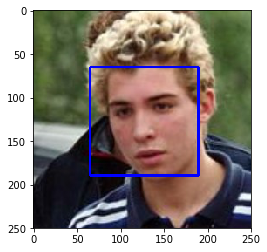

In [4]:
# Extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[2])

# Convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find faces in image
faces = face_cascade.detectMultiScale(gray)

# Print number of faces detected in the image
print('Number of faces detected:', len(faces))

# Get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# Convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

Create a function that returns `True` if a human face is detected in an image and `False` otherwise.

In [3]:
def human_face_detector(image_path):
    ''' Verify if a human face was detected in a given image path
    '''
    
    # load color (BGR) image
    color_image = cv2.imread(image_path)
    
    # Convert BGR image to grayscale
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
    
    # Find faces in image
    faces = face_cascade.detectMultiScale(gray_image)
    
    # Obtain number of detected human faces
    number_detected_faces = len(faces)
    
    # Check if there are human faces detected
    detected_face = number_detected_faces > 0
    
    return detected_face

In [4]:
def verify_detector_performance(func, expected_human_faces, expected_dog_breeds):
    ''' Verify the performance of a given detector.
        It determines the number of detected human and 
        dog breed images.
    '''
    # Use only 100 images for the verification
    number_images = 100
    
    # Obtain human and dog images for verification
    human_files_short = human_files[:number_images]
    dog_files_short = dog_files[:number_images]

    # Count the number of detected human faces
    detected_human_faces = 0

    # Count the number of detected dog breeds
    detected_dog_breeds = 0

    # Iterates throw each human image to detect a face
    for human_image in human_files_short:
        detected_human_faces += func(human_image)

    # Iterates throw each dog image to detect
    for dog_image in dog_files_short:
        detected_dog_breeds += func(dog_image)

    print("Percentage of detected human faces is: {}%. Expected: {}%".format(detected_human_faces, expected_human_faces))
    print("Percentage of detected dog breeds is: {}%. Expected: {}%".format(detected_dog_breeds, expected_dog_breeds))

In [7]:
# Check the performance of the human face detector
verify_detector_performance(func = human_face_detector,
                            expected_human_faces = 100, 
                            expected_dog_breeds = 0)

Percentage of detected human faces is: 98%. Expected: 100%
Percentage of detected dog breeds is: 17%. Expected: 0%


<a id='step3'></a>
## Step 3: Data Exploration - Dog breeds dataset

In [8]:
# Print number of images in dog breeds dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


In [9]:
# Contains the types of data
types_data = ['train', 'valid', 'test']

# Check the number of images per data type
for type_data in types_data:
    images = np.array(glob("/data/dog_images/{}/*/*".format(type_data)))

    print("There are {} total {} dog images.".format(len(images), type_data))

There are 6680 total train dog images.
There are 835 total valid dog images.
There are 836 total test dog images.


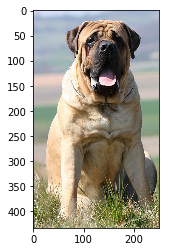

In [10]:
# load color (BGR) image
bgr_image = cv2.imread(dog_files[2])

# Convert BGR image to RGB for plotting
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

# Display the image, along with bounding box
plt.imshow(rgb_image)
plt.show()

<a id='step4'></a>
## Step 4: Create Utilities Functions

Create utilities functions and global variables that are going to be necessary in the entire project.

In [5]:
# Mean and standard deviation of the images color channels
mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dogs images directory path
data_directory = '/data/dog_images'

# Total classes of dog breeds
number_of_dog_classes = 133 

In [6]:
def create_transforms():
    ''' Create transforms for the training, validation, and testing sets
    '''

    # Tranform for the training data using image augmentation
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean_values, std_values)])

    # Tranform for the validation data
    valid_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean_values, std_values)])

    # Tranform for the testing data
    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean_values, std_values)])
    
    result_transforms = {"train": train_transforms,
                         "valid": valid_transforms,
                         "test":  test_transforms
                        }
    
    return result_transforms

In [7]:
def create_datasets(data_directory, all_transforms):
    ''' Create data sets for the training, validation and testing sets
    '''
    
    # Set training, validation and testing data directories
    train_dir = data_directory + '/train'
    valid_dir = data_directory + '/valid'
    test_dir = data_directory + '/test'

    # Load the datasets with ImageFolder

    # Training dataset
    train_data = datasets.ImageFolder(train_dir, transform=all_transforms['train'])

    # Validation dataset
    valid_data = datasets.ImageFolder(valid_dir, transform=all_transforms['valid'])

    # Testing dataset
    test_data = datasets.ImageFolder(test_dir, transform=all_transforms['test'])
    
    result_datasets = {"train": train_data,
                       "valid": valid_data,
                       "test":  test_data
                       }
    
    return result_datasets

In [8]:
def make_weights_for_balanced_classes(images, nclasses):   
    ''' Create weights for balancing classes
    '''
    
    # Contain number of images per class
    count = [0] * nclasses      
    
    # Count the number of images per class label
    for item in images:                                                         
        count[item[1]] += 1          
        
    # Create an entry per each class label
    weight_per_class = [0.] * nclasses    
    
    # Sum the total number of images
    N = float(sum(count))                
    
    # Calculate the balanced weight per each class
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])   
        
    # Contain the balanced weight for each image
    weight = [0] * len(images)         
    
    # Associate the new balanced weight for each image according with its label
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]     
        
    return weight 

In [9]:
def create_dataloaders(all_datasets):
    ''' Create data loaders for the training, validation and testing sets
    '''

    # Specify the batch size
    batch_size_value = 64
    
    # Contains the types of data
    types_data = ['train', 'valid', 'test']
    
    result_dataloaders = {}
    
    # Create dataloader for each data type
    for data_type in types_data:
        # For unbalanced dataset we create a weighted sampler                       
        weights = make_weights_for_balanced_classes(all_datasets[data_type].imgs, len(all_datasets[data_type].classes))                                                                
        weights = torch.DoubleTensor(weights)                                       
        sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))  

        # Dataloader
        loader = torch.utils.data.DataLoader(all_datasets[data_type], 
                                             batch_size=batch_size_value, 
                                             sampler = sampler)    
        
        result_dataloaders[data_type] = loader
        
    
    return result_dataloaders

In [10]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Tranform for the testing data
    test_transforms = create_transforms()['test']
    
    # Process a PIL image for use in a PyTorch model
    with Image.open(image_path) as image:  
        image = test_transforms(image)
        
    return image

In [11]:
def show_image(image, ax=None, title=''):
    ''' Imshow for Tensor
    '''
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    image = std_values * image + mean_values
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

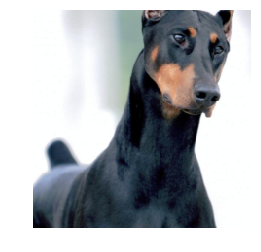

In [18]:
# Verify the functionality of "process_image" and "show_image" functions

# Dog image for verification
dog_image = dog_files[100]

# Processed image
processed_image = process_image(dog_image)

# Show dog image
show_image(processed_image);

In [12]:
def train(n_epochs, loaders, model, optimizer, criterion, save_path):
    ''' Train the classifier layers with backpropagation using the pre-trained 
        network to get the features
    '''
    
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    # Iterate through each epoch
    for epoch in range(1, n_epochs+1):
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # Set the model to training mode
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # Move data and target tensors to the default device
            data, target = data.to(device), target.to(device)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Pass through the network
            output = model(data)
            
            # Calculate loss with the output
            loss = criterion(output, target)
            
            # Make a backward pass through the network to calculate the gradients
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Update training loss
            train_loss += loss.item()
            
            # Only print training loss each 100 times
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
                
        # Set the model to evaluation mode
        model.eval()
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # Move data and target tensors to the default device
            data, target = data.to(device), target.to(device)
            
            # Turn off dropout during validation
            with torch.no_grad():
                # Pass through the network
                output = model(data)
                
                # Calculate loss with the output
                loss = criterion(output, target)
                
                # Update validation loss
                valid_loss += loss.item()

            # Only print training/validation loss each 100 times
            if batch_idx % 100 == 0:
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                    epoch, 
                    train_loss,
                    valid_loss
                    ))

            # Save the model if validation loss has decreased
            if valid_loss < valid_loss_min:
                # Save the model
                torch.save(model.state_dict(), save_path)
                
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                
                # Update new minomum validation loss
                valid_loss_min = valid_loss
            
    # return trained model
    return model

In [13]:
def test(loaders, model, model_name, criterion):
    ''' Test model on the test dataset, measuring F1 score metric
    '''
    
    # Test loss
    test_loss = 0.0
    
    # Set the model to evaluation mode
    model.eval()
    
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []
    
    # Turn off dropout during testing
    with torch.no_grad():
        for data, target in loaders['test']:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # Calculate loss with the output
            loss = criterion(output, target)
                
            # Update testing loss
            test_loss += loss.item()

            # Convert output probabilities to predicted class
            _, predicted = torch.max (output.data, 1)
            
            # Update total number of tested images
            total += target.size(0)
            
            # Update all real and predictec image labels
            all_predictions.extend(predicted.tolist())
            all_labels.extend(target.tolist())
            
    # Calculate metrics for each label, and find their average weighted by support 
    # (the number of true instances for each label).
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Print some metrics
    print("Metrics on test images for {} model:".format(model_name))
    print("F1-Score: {:.3f}".format(f1))
    print("Total of images: {}".format(total))

In [14]:
def choose_model(arch):
    ''' Choose a pre-trained network for a given architecture
    '''
    
    # List of pretrained models to used
    available_models = {'vgg16':[models.vgg16(pretrained=True), models.vgg16(pretrained=True).classifier[6].in_features],
                        'vgg19':[models.vgg19(pretrained=True), models.vgg19(pretrained=True).classifier[6].in_features],
                        'resnet50':[models.resnet50(pretrained=True), models.resnet50(pretrained=True).fc.in_features]
                       }
    
    
    # Look for the model for the given architecture
    if arch in available_models:
        # Return model and model input_features size
        return available_models[arch][0], available_models[arch][1]
    else:
        print('There is not a pre-trained model for the specified architecture: {}'.format(arch))


In [15]:
def load_pretrained_model(drop_out, output_dim, arch):
    ''' Load a pre-trained network for a given architecture
    '''
    
    print("Loading a pre-trained {} network".format(arch))
    
    # Load a pre-trained network
    model, in_features = choose_model(arch=arch)
    
    # Create new last linear layer for network classifier
    new_last_layer = nn.Linear(in_features, out_features=output_dim, bias=True)
    
    # Update model classifier
    if(arch == "resnet50"):
        # Freeze parameters so it doesn't backprop through them
        for param in model.parameters():
            param.requires_grad = False
        
        # Add mew last linear layer into the model classifier
        model.fc = new_last_layer
    else:
        # Freeze parameters so it doesn't backprop through them
        for param in model.features.parameters():
            param.requires_grad = False
        
        # Add mew last linear layer into the model classifier
        idx_last_linear_layer = 6
        model.classifier[idx_last_linear_layer] = new_last_layer
    
    return model

<a id='step5'></a>
## Step 5: Create Benchmark Model

As benchmark, this project used a pre-trained VGG-16 model using transfer learning to classify the images. This model has been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of 1000 categories.

In [16]:
# Define some settings values used for the benchmark and proposed model
# This will help to have an initial base model

drop_out = 0.2
out_features = number_of_dog_classes

number_epochs = 20

In [17]:
# Create data loaders used in the entire project

# Create transforms for the training, validation, and testing sets
all_transforms = create_transforms()

# Create datasets for the training, validation and testing sets
all_datasets = create_datasets(data_directory=data_directory, 
                               all_transforms=all_transforms)

# Create data loaders for the training, validation and testing sets
all_dataloaders = create_dataloaders(all_datasets=all_datasets)

In [34]:
# Instantiate the VGG-16 benchmark model
model_benchmark = load_pretrained_model(drop_out, out_features, arch="vgg16")

# loss function
criterion_benchmark = nn.CrossEntropyLoss()

# Optimizer
optimizer_benchmark = optim.Adam(model_benchmark.classifier.parameters(), lr = 0.001)

# Move model to the default device
model_benchmark.to(device)

Loading a pre-trained vgg16 network


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [35]:
# Define the loaders
loaders_benchmark = {'train': all_dataloaders['train'],
                     'valid': all_dataloaders['valid'],
                     'test': all_dataloaders['test']}

In [36]:
# Train the benchmark model
model_benchmark = train(n_epochs = number_epochs, 
                        loaders = loaders_benchmark, 
                        model = model_benchmark, 
                        optimizer = optimizer_benchmark, 
                        criterion = criterion_benchmark, 
                        save_path = 'model_benchmark.pt')

Epoch 1, Batch 1 loss: 4.997956
Epoch 1, Batch 101 loss: 343.143859
Epoch: 1 	Training Loss: 354.675240 	Validation Loss: 1.616330
Validation loss decreased (inf --> 1.616330).  Saving model ...
Epoch 2, Batch 1 loss: 2.858212
Epoch 2, Batch 101 loss: 276.009678
Epoch: 2 	Training Loss: 287.023449 	Validation Loss: 1.815554
Epoch 3, Batch 1 loss: 2.396430
Epoch 3, Batch 101 loss: 271.897658
Epoch: 3 	Training Loss: 282.314201 	Validation Loss: 1.030713
Validation loss decreased (1.616330 --> 1.030713).  Saving model ...
Epoch 4, Batch 1 loss: 2.564722
Epoch 4, Batch 101 loss: 275.185004
Epoch: 4 	Training Loss: 286.055127 	Validation Loss: 1.332567
Epoch 5, Batch 1 loss: 3.258227
Epoch 5, Batch 101 loss: 272.550095
Epoch: 5 	Training Loss: 283.052277 	Validation Loss: 1.135946
Epoch 6, Batch 1 loss: 2.256529
Epoch 6, Batch 101 loss: 270.359117
Epoch: 6 	Training Loss: 280.982961 	Validation Loss: 1.180765
Epoch 7, Batch 1 loss: 2.753962
Epoch 7, Batch 101 loss: 265.028067
Epoch: 7 	Tra

In [37]:
# Load the model that got the best validation loss
model_benchmark.load_state_dict(torch.load('model_benchmark.pt'))

In [43]:
# Test the benchmark model
test(loaders = loaders_benchmark, 
     model = model_benchmark, 
     model_name = "VGG-16 benchmark",
     criterion=criterion_benchmark)

Metrics on test images for VGG-16 benchmark model:
F1-Score: 0.660
Total of images: 836


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<a id='step6'></a>
## Step 6: Create Proposed Model

VGG-19 and ResNet50 models were used and analyzed to measure their performance. Both models were compared according with the F1 score metric and the best one was chosen. The objective was to beat the benchmark model. 

### Analyze ResNet50 model

Below is the procedured used to analyze the RestNet50 model.

In [45]:
# Instantiate the ResNet50 model
model_resnet50 = load_pretrained_model(drop_out, out_features, arch="resnet50")

# loss function
criterion_resnet50 = nn.CrossEntropyLoss()

# Optimizer
optimizer_resnet50 = optim.Adam(model_resnet50.fc.parameters(), lr = 0.001)

# Move model to the default device
model_resnet50.to(device)

Loading a pre-trained resnet50 network


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [46]:
# Define the loaders
loaders_resnet50 = {'train': all_dataloaders['train'],
                    'valid': all_dataloaders['valid'],
                    'test': all_dataloaders['test']}

In [47]:
# Train the ResNet50 model
model_resnet50 = train(n_epochs = number_epochs,
                       loaders = loaders_resnet50, 
                       model = model_resnet50, 
                       optimizer = optimizer_resnet50, 
                       criterion = criterion_resnet50, 
                       save_path = 'model_resnet50.pt')

Epoch 1, Batch 1 loss: 4.938708
Epoch 1, Batch 101 loss: 296.247159
Epoch: 1 	Training Loss: 303.573172 	Validation Loss: 1.149852
Validation loss decreased (inf --> 1.149852).  Saving model ...
Epoch 2, Batch 1 loss: 1.900003
Epoch 2, Batch 101 loss: 141.766103
Epoch: 2 	Training Loss: 147.332783 	Validation Loss: 0.554510
Validation loss decreased (1.149852 --> 0.554510).  Saving model ...
Epoch 3, Batch 1 loss: 1.229169
Epoch 3, Batch 101 loss: 113.842924
Epoch: 3 	Training Loss: 118.385777 	Validation Loss: 0.583282
Epoch 4, Batch 1 loss: 0.985929
Epoch 4, Batch 101 loss: 99.985943
Epoch: 4 	Training Loss: 103.880450 	Validation Loss: 0.560677
Epoch 5, Batch 1 loss: 0.803433
Epoch 5, Batch 101 loss: 93.168142
Epoch: 5 	Training Loss: 97.123107 	Validation Loss: 0.666592
Epoch 6, Batch 1 loss: 1.033780
Epoch 6, Batch 101 loss: 85.508783
Epoch: 6 	Training Loss: 88.729021 	Validation Loss: 0.641207
Epoch 7, Batch 1 loss: 0.670748
Epoch 7, Batch 101 loss: 83.988795
Epoch: 7 	Training 

In [48]:
# Load the model that got the best validation loss
model_resnet50.load_state_dict(torch.load('model_resnet50.pt'))

In [49]:
# Test the ResNet50 model
test(loaders = loaders_resnet50, 
     model = model_resnet50, 
     model_name = "ResNet50",
     criterion=criterion_resnet50)

Metrics on test images for ResNet50 model:
F1-Score: 0.855
Total of images: 836


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Analyze VGG-19 model

Below is the procedured used to analyze the VGG-19 model.

In [23]:
# Instantiate the VGG-19 model
model_vgg19 = load_pretrained_model(drop_out, out_features, arch="vgg19")

# loss function
criterion_vgg19 = nn.CrossEntropyLoss()

# Optimizer
optimizer_vgg19 = optim.Adam(model_vgg19.classifier.parameters(), lr = 0.001)

# Move model to the default device
model_vgg19.to(device)

Loading a pre-trained vgg19 network


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [24]:
# Define the loaders
loaders_vgg19 = {'train': all_dataloaders['train'],
                 'valid': all_dataloaders['valid'],
                 'test': all_dataloaders['test']}

In [25]:
# Train the VGG-19 model
model_vgg19 = train(n_epochs = number_epochs,
                    loaders = loaders_vgg19, 
                    model = model_vgg19, 
                    optimizer = optimizer_vgg19, 
                    criterion = criterion_vgg19, 
                    save_path = 'model_vgg19.pt')

Epoch 1, Batch 1 loss: 5.083748
Epoch 1, Batch 101 loss: 330.577298
Epoch: 1 	Training Loss: 341.394466 	Validation Loss: 1.746346
Validation loss decreased (inf --> 1.746346).  Saving model ...
Epoch 2, Batch 1 loss: 2.492656
Epoch 2, Batch 101 loss: 261.568284
Epoch: 2 	Training Loss: 272.351534 	Validation Loss: 1.502999
Validation loss decreased (1.746346 --> 1.502999).  Saving model ...
Epoch 3, Batch 1 loss: 2.472014
Epoch 3, Batch 101 loss: 263.267668
Epoch: 3 	Training Loss: 273.616208 	Validation Loss: 1.008485
Validation loss decreased (1.502999 --> 1.008485).  Saving model ...
Epoch 4, Batch 1 loss: 2.895385
Epoch 4, Batch 101 loss: 255.847217
Epoch: 4 	Training Loss: 265.801659 	Validation Loss: 1.205689
Epoch 5, Batch 1 loss: 2.154514
Epoch 5, Batch 101 loss: 263.657102
Epoch: 5 	Training Loss: 275.707001 	Validation Loss: 1.217191
Epoch 6, Batch 1 loss: 2.780228
Epoch 6, Batch 101 loss: 261.168629
Epoch: 6 	Training Loss: 271.140313 	Validation Loss: 1.296800
Epoch 7, Bat

In [26]:
# Load the model that got the best validation loss
model_vgg19.load_state_dict(torch.load('model_vgg19.pt'))

In [27]:
# Test the VGG-19 model
test(loaders = loaders_vgg19, 
     model = model_vgg19, 
     model_name = "VGG-19",
     criterion=criterion_vgg19)

Metrics on test images for VGG-19 model:
F1-Score: 0.665
Total of images: 836


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


<a id='step7'></a>
## Step 7: Model Refinement

After having decided to use the ResNet50 model, it was necessary to pass it through a refinement process which consisted of some hyperparameters optimization or tuning with the goal of achieving an even higher F1 score metric. 

The hyperparameters tuned were the following:

    * Dropout
    * epochs

In [50]:
# Define some settings values used for tunning-up the model

new_drop_out = 0.3
new_number_epochs = 40

In [51]:
# Instantiate the model to tune-up
model_improved = load_pretrained_model(new_drop_out, out_features, arch="resnet50")

# loss function
criterion_improved = nn.CrossEntropyLoss()

# Optimizer
optimizer_improved = optim.Adam(model_improved.fc.parameters(), lr = 0.001)

# Move model to the default device
model_improved.to(device)

Loading a pre-trained resnet50 network


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [52]:
# Define the loaders
loaders_improved = {'train': all_dataloaders['train'],
                    'valid': all_dataloaders['valid'],
                    'test': all_dataloaders['test']}

In [53]:
# Train the model to improve it
model_improved = train(n_epochs = new_number_epochs,
                       loaders = loaders_improved, 
                       model = model_improved, 
                       optimizer = optimizer_improved, 
                       criterion = criterion_improved, 
                       save_path = 'model_improved.pt')

Epoch 1, Batch 1 loss: 4.978565
Epoch 1, Batch 101 loss: 297.114648
Epoch: 1 	Training Loss: 304.234922 	Validation Loss: 1.232078
Validation loss decreased (inf --> 1.232078).  Saving model ...
Epoch 2, Batch 1 loss: 1.703623
Epoch 2, Batch 101 loss: 140.725977
Epoch: 2 	Training Loss: 146.258012 	Validation Loss: 0.784073
Validation loss decreased (1.232078 --> 0.784073).  Saving model ...
Epoch 3, Batch 1 loss: 1.155729
Epoch 3, Batch 101 loss: 111.841534
Epoch: 3 	Training Loss: 115.603813 	Validation Loss: 0.643813
Validation loss decreased (0.784073 --> 0.643813).  Saving model ...
Epoch 4, Batch 1 loss: 1.117250
Epoch 4, Batch 101 loss: 101.373731
Epoch: 4 	Training Loss: 105.396153 	Validation Loss: 0.529307
Validation loss decreased (0.643813 --> 0.529307).  Saving model ...
Epoch 5, Batch 1 loss: 0.937933
Epoch 5, Batch 101 loss: 91.203197
Epoch: 5 	Training Loss: 94.707215 	Validation Loss: 0.534219
Epoch 6, Batch 1 loss: 0.789508
Epoch 6, Batch 101 loss: 88.542351
Epoch: 6 

In [56]:
# Load the model that got the best validation loss
model_improved.load_state_dict(torch.load('model_improved.pt'))

In [57]:
# Test the improved model
test(loaders = loaders_improved, 
     model = model_improved, 
     model_name = "improved ResNet50",
     criterion=criterion_improved)

Metrics on test images for improved ResNet50 model:
F1-Score: 0.843
Total of images: 836


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<a id='step8'></a>
## Step 8: Model Evaluation and Validation

Built a pipeline to process real-world, user-supplied images. Given an image of a dog, the algorithm identified an estimate of the canine’s breed. If supplied an image of a human, the code identified the resembling dog breed.

In [58]:
def predict_breed_transfer(img_path, model):
    ''' Load the image and return the predicted dog breed
    ''' 
    
    # Preprocess the image
    pytorch_np_image = process_image(img_path)
    
    # Changing from numpy to pytorch tensor
    pytorch_tensor = torch.tensor(pytorch_np_image)
    pytorch_tensor = pytorch_tensor.float()
    
    # Used to make size of torch as expected (batch size = 1)
    pytorch_tensor = pytorch_tensor.unsqueeze(0)
    
    # Move model to CPU
    model = model.cpu()
    
    # Set model into evaluation mode
    model.eval()
    
    # Get model output
    output = model(pytorch_tensor)
    
    # Obtain predicted class index
    predicted_index = torch.max(output, 1)[1].item()
        
    # List of class names by index
    class_names = [item[4:].replace("_", " ") for item in loaders_improved['train'].dataset.classes]

    # Use prediction index to get dog breed
    breed = class_names[predicted_index]
    
    return breed

In [59]:
def run_app(img_path, is_human):
    ''' If supplied an image of a human, the code identifies the resembling dog breed. 
        If it is a dog image, it predicts the dog breed.
    '''
    
    # Obtain predicted dog breed
    predicted_breed = predict_breed_transfer(img_path, model_improved)
    
    # Check if a human face is detected in the image
    if is_human:
        print("Hello human!")
        print("You look like a ...\n {}".format(predicted_breed))
    # Check if a dog is detected in the image
    else:
        print("Hello dog!")
        print("Your predicted breed is...: \n{}".format(predicted_breed))

    # Show image
    plt.imshow(Image.open(img_path))
    plt.show()
    print("*************************")

### Algorithm Verification

Tested the solution model with images from the datasets to see the model in work.

Hello human!
You look like a ...
 Chihuahua


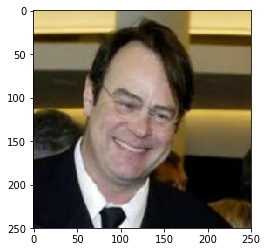

*************************
Hello human!
You look like a ...
 Doberman pinscher


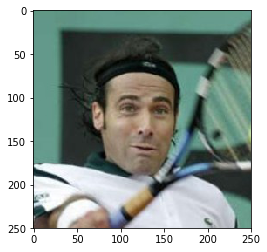

*************************
Hello human!
You look like a ...
 American water spaniel


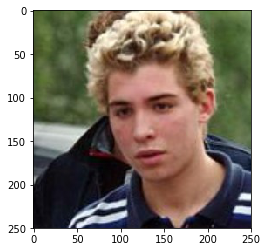

*************************


In [60]:
# Verify the algorithm for human images
for file in human_files[:3]:
    run_app(file, is_human=True)

Input is: /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg
Hello dog!
Your predicted breed is...: 
Mastiff


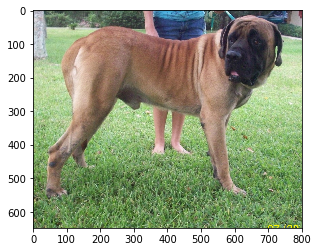

*************************
Input is: /data/dog_images/train/059.Doberman_pinscher/Doberman_pinscher_04172.jpg
Hello dog!
Your predicted breed is...: 
Doberman pinscher


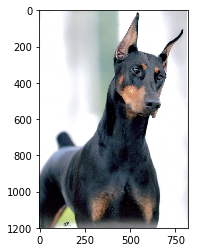

*************************
Input is: /data/dog_images/train/031.Borzoi/Borzoi_02161.jpg
Hello dog!
Your predicted breed is...: 
Borzoi


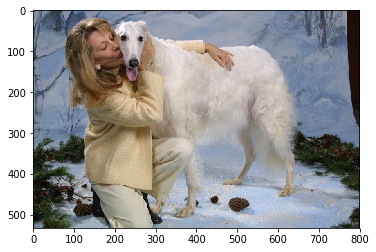

*************************


In [61]:
# Verify the algorithm for dog images
print("Input is: " + dog_files[0])
run_app(dog_files[0], is_human=False)

print("Input is: " + dog_files[100])
run_app(dog_files[100], is_human=False)

print("Input is: " + dog_files[200])
run_app(dog_files[200], is_human=False)